In [1]:
import numpy as np
import random

In [2]:
#Return Dice Value Sorted Small to big, when 
##Alternate Reward System
# def indexOfSorted(sortMe):
#   s = sorted(range(len(sortMe)), key=lambda k: sortMe[k])
#   return [i+1 for i in s]

class DiceGame2():

    def __init__(self):
        self.state = np.zeros((5,2))
        self.top = [1000,4,4,4,4] #Arb top for Col 0, High so it doesn't Accidentally Trigger Col Done Count
        self.dice = (np.random.randint(1, 5),np.random.randint(1, 5))
        self.state[0] = self.dice
        self.blackDots = 2
        self.turn = 0 #Total Turns, or how many times opponent had a chance to counter attack
        self.round = 0 #Rounds within a current turn, used to track reward
        self.cummu = 0
        self.reward = 0
        self.bust = False
        self.done = False
        
    def step(self, action):
        #Code for testing repeated end state 
        if self.done:
            self.dice = (np.random.randint(1, 5),np.random.randint(1, 5))
            return self.state, self.dice, self.blackDots, self.turn, self.reward, self.done
        else:
            assert action in [0,1,2,3]
            # 0 is dice 1 and stay
            # 1 is dice 1 and go
            # 2 is dice 2 and stay
            # 3 is dice 2 and go

            dicePick = self.dice[action//2] #Numerical Value of Dice Picked
            stay = (action%2 == 0) #Stay or push value

            #Code for checking if move is legal because top has been reached previously
            #in either Black or Colors
            if any (X >= self.top[dicePick] for X in self.state[dicePick]):
                self.bust=True

            #Code for checking if move is illegal due to out of black dots and attempting to place another
            if self.state[dicePick][-1]==0 and self.blackDots<=0:
                self.bust=True

            #Bust, Reset all Black Dots to 0 and increase Turn. Reset and set what is needed for next round
            if self.bust:
                for i in range(len(self.state)):
                    self.state[i,-1]=0
                self.turn+=1
                self.blackDots=2
                self.bust=False
                self.reward= -10 
                self.dice = (np.random.randint(1, 5),np.random.randint(1, 5))
                self.state[0] = self.dice

            #Increase picked value. Decrease BlackDot count if needed
            else:
                #If new blackdot placement for turn, initialize blackdot
                if self.state[dicePick][-1]==0:
                    self.state[dicePick][-1]=self.state[dicePick][0]
                    self.blackDots-=1            
                self.state[dicePick][-1]+=1
                self.round+=1
                self.reward= -1 
                #self.reward=indexOfSorted(env.state[1:,0]).index(dicePick)/4
                self.dice = (np.random.randint(1, 5),np.random.randint(1, 5))
                self.state[0] = self.dice

                #If stay also chosen, increase turn count, lock in and reset blackDots, reset BD count
                if stay:
                    for i in range(1,5):                        
                        if self.state[i][-1]>0:
                            self.state[i][0]=self.state[i][-1] 
                            self.state[i][-1]=0
                    self.turn+=1
                    self.reward= (-100 * self.blackDots) -1
                    self.blackDots=2
                    self.bust=False
                    self.cummu=0
                    self.round=0
                    
                    countDone=0
                    for i in range(1,5):
                        if self.state[i,0]>=self.top[i]:
                            countDone+=1
                    if (countDone>=2):
                        self.done = True
                        self.reward = 1000 #Arb Reward for completing Game
                

            return self.state, self.dice, self.blackDots, self.turn, self.reward, self.done
        
    def softreset(self):
        self.turn+=1
        self.blackDots=2
        self.bust=False
        self.round=0

    def reset(self):
        self.state = np.zeros((5,2))
        self.top = [1000,4,4,4,4] 
        self.dice = (np.random.randint(1, 5),np.random.randint(1, 5))
        self.state[0] = self.dice
        self.blackDots = 2
        self.turn = 0
        self.reward = 0
        self.bust = False
        self.done = False
        return self.state, self.dice, self.blackDots, self.turn, self.reward, self.done

    def stats(self):
        return self.state, self.dice, self.blackDots, self.turn, self.reward, self.done

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer, LSTM
from tensorflow.keras.optimizers import Adam

In [17]:
from tensorflow import keras
try:
    model = keras.models.load_model('AllStepsNegModel')
except:
    model = Sequential()
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(16, activation='relu'))
    #model.add(Dense(512, activation='relu'))#
    #model.add(Dense(256, activation='relu'))#
    model.add(Dense(4, activation='linear'))
    model.compile(loss='huber_loss', optimizer='adam', metrics=['mae'])

In [18]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 32)                352       
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_23 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 68        
Total params: 2,276
Trainable params: 2,276
Non-trainable params: 0
_________________________________________________________________


In [11]:
def binarizedBoard(env):
  #Binarize Env Board into:
  #Dice Value 1, Dice Value 2, BlackDot1 Row Position, BlackDot2 Row Position, Turn Count
  #RedDot Col Position on Row1
  #RedDot Col Position on Row2
  #...
  #RedDot Col Position on RowX
  maxWidth = max(max(env.top[1:])+1,5)
  maxLen= len(env.top)
  matrix= np.zeros((maxLen,maxWidth))
  BDList=[]
  for i, value in enumerate(env.state[1:,-1], start=1):
    if value>0:
      BDList.append(i)
  while len(BDList)<2:
    BDList.append(0)
  #Row 0  
  matrix[0,0:5]=env.dice[0],env.dice[1], BDList[0], BDList[1], env.turn
  #Row X
  for i, value in enumerate(env.state[1:,0], start=1):
    matrix[i, int(value)]=1

  return matrix

In [8]:
def generate1away(env):
  #Generate Boards that are 1 away from winning, 
  env.reset()
  col=[1,2,3,4]
  for i in col:
    env.state[i][0]= np.random.randint(0, 3)
  
  bestDice= np.random.randint(0, 2) #Get the dice position that wins the game
  winCol = env.dice[bestDice] #Get the value of the dice in that position
  col.remove(winCol)
  topCol= col[np.random.randint(0, len(col))]
  col.remove(topCol)  

  black1=np.random.randint(0, 2)
  black2=np.random.randint(0, 2)
  env.blackDots= 2- int(black1 + black2)

  env.state[topCol][black1]=4
  
  bugFix= env.state[winCol,0]
  if bugFix < 3:
    env.state[winCol][black2]=3

  if env.blackDots == 1:
    oneMore= np.random.randint(0, 2)
    env.blackDots -= oneMore
    luckyWinner=random.choice(col)
    env.state[luckyWinner][oneMore] = env.state[luckyWinner,0]+1
  
  env.turn= np.random.randint(5, 15)



  return env.state, bestDice*2

In [9]:
def gen2away(env):
  teststate, answer= generate1away(env)
  candidateList=[]
  for i, row in enumerate(teststate[1:]):
    for j, col in enumerate(row):
      if teststate[i+1,j]==3:        
        candidateList.append([i+1,j])
  winner = random.choice(candidateList)
  if winner[-1]==1 and teststate[winner[0],0] ==2:
    teststate[winner[0],0]-=1
  teststate[winner[0],winner[1]]-=1
  env.state= teststate
  return env.state, answer

In [10]:
def  NNInput(envState):
    try:
        size= envState.size
        return envState.reshape(1,size)
    except:
        return np.array(envState).reshape(1,1)
    

In [11]:
#Train on 1 away and 2 away more often
import time

start=time.perf_counter()

discountFactor = 0.7
num_eps = 1000
exploreVal=1.25
turn_list=[]
r_list=[]
env = DiceGame2()
for i in range(num_eps):
    env.reset()
    #explore *= decay
    if i%5!=0:
      if i %2==0:
        generate1away(env)
      else:
        gen2away(env)
    explore = exploreVal - i/num_eps
    print("Episode {} of {}".format(i+1, num_eps))
    done= False
    count=0
    board=env.state
    turn=env.turn
    r_sum = 0 
    while not done:
        s = NNInput(env.state)
        PredQTable=model.predict(s)

        if np.random.random() < explore:
              action = np.random.randint(0, 4)
        else:
              action = np.argmax(PredQTable)   
        board,_,_,turn,reward, done = env.step(action)
        newS= NNInput(env.state)

        futureReward = reward + min(discountFactor * np.max(model.predict(newS)), 1000)
        
        target_vec =  PredQTable*(1-discountFactor)
        target_vec[0,action] = futureReward

        model.fit(NNInput(s), target_vec.reshape(1,4), verbose=0)
        count+=1
        
    
#Train Normally    
for i in range(num_eps):
    env.reset()
    #explore *= decay
    explore = exploreVal - i/num_eps
    print("Full Game Episode {} of {}".format(i+1, num_eps))
    done= False
    count=0
    board=env.state
    turn=env.turn
    r_sum = 0 
    while not done:
        s = NNInput(env.state)
        PredQTable=model.predict(s)

        if np.random.random() < explore:
              action = np.random.randint(0, 4)
        else:
              action = np.argmax(PredQTable)   
        board,_,_,turn,reward, done = env.step(action)
        newS= NNInput(env.state)

        futureReward = reward + min(discountFactor * np.max(model.predict(newS)), 1000)
        
        target_vec =  PredQTable*(1-discountFactor)
        target_vec[0,action] = futureReward

        model.fit(NNInput(s), target_vec.reshape(1,4), verbose=0)
        count+=1
        r_sum += futureReward
        
    turn_list.append(env.turn)
    r_list.append(r_sum)
    
print(time.perf_counter()-start)

Episode 1 of 1000
Episode 2 of 1000
Episode 3 of 1000
Episode 4 of 1000
Episode 5 of 1000
Episode 6 of 1000
Episode 7 of 1000
Episode 8 of 1000
Episode 9 of 1000
Episode 10 of 1000
Episode 11 of 1000
Episode 12 of 1000
Episode 13 of 1000
Episode 14 of 1000
Episode 15 of 1000
Episode 16 of 1000
Episode 17 of 1000
Episode 18 of 1000
Episode 19 of 1000
Episode 20 of 1000
Episode 21 of 1000
Episode 22 of 1000
Episode 23 of 1000
Episode 24 of 1000
Episode 25 of 1000
Episode 26 of 1000
Episode 27 of 1000
Episode 28 of 1000
Episode 29 of 1000
Episode 30 of 1000
Episode 31 of 1000
Episode 32 of 1000
Episode 33 of 1000
Episode 34 of 1000
Episode 35 of 1000
Episode 36 of 1000
Episode 37 of 1000
Episode 38 of 1000
Episode 39 of 1000
Episode 40 of 1000
Episode 41 of 1000
Episode 42 of 1000
Episode 43 of 1000
Episode 44 of 1000
Episode 45 of 1000
Episode 46 of 1000
Episode 47 of 1000
Episode 48 of 1000
Episode 49 of 1000
Episode 50 of 1000
Episode 51 of 1000
Episode 52 of 1000
Episode 53 of 1000
Ep

In [ ]:
#Exploit 95%, Explore 5%
discountFactor = 0.7

num_eps = 1000

turn_list=[]
r_list=[]
env = DiceGame2()

for i in range(num_eps):
    env.reset()
    explore = 0.05
    print("Full Game Episode {} of {}".format(i+1, num_eps))
    done= False
    count=0
    r_sum = 0 
    while not done:
        s = NNInput(env.state)
        PredQTable=model.predict(s)
        #print(env.stats)
        #print(PredQTable)

        if np.random.random() < explore:
              action = np.random.randint(0, 4)
        else:
              action = np.argmax(PredQTable)   
        board,_,_,turn,reward, done = env.step(action)

        count+=1
        r_sum += futureReward
        
    turn_list.append(env.turn)
    r_list.append(r_sum)

Full Game Episode 1 of 1000
Full Game Episode 2 of 1000
Full Game Episode 3 of 1000
Full Game Episode 4 of 1000
Full Game Episode 5 of 1000
Full Game Episode 6 of 1000
Full Game Episode 7 of 1000
Full Game Episode 8 of 1000
Full Game Episode 9 of 1000
Full Game Episode 10 of 1000
Full Game Episode 11 of 1000
Full Game Episode 12 of 1000
Full Game Episode 13 of 1000
Full Game Episode 14 of 1000
Full Game Episode 15 of 1000
Full Game Episode 16 of 1000
Full Game Episode 17 of 1000
Full Game Episode 18 of 1000
Full Game Episode 19 of 1000
Full Game Episode 20 of 1000
Full Game Episode 21 of 1000
Full Game Episode 22 of 1000
Full Game Episode 23 of 1000
Full Game Episode 24 of 1000
Full Game Episode 25 of 1000
Full Game Episode 26 of 1000
Full Game Episode 27 of 1000
Full Game Episode 28 of 1000
Full Game Episode 29 of 1000
Full Game Episode 30 of 1000
Full Game Episode 31 of 1000
Full Game Episode 32 of 1000
Full Game Episode 33 of 1000
Full Game Episode 34 of 1000
Full Game Episode 35 of

In [303]:
#Exploring NN Choices

env.reset()
generate1away()
gen2away()

s= NNInput(env.state)
PredQTable=model.predict(s)
PredQTable

array([[-0.4391505 , -0.44913724, -0.4334298 , -0.43301243]],
      dtype=float32)

<AxesSubplot:>

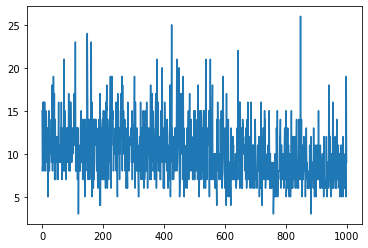

In [12]:
#len(turn_list)
import seaborn
seaborn.lineplot(x=range(len(turn_list)), y=turn_list)

<AxesSubplot:>

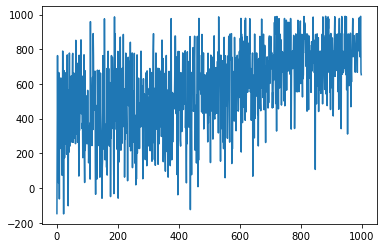

In [13]:
seaborn.lineplot(x=range(len(r_list)), y=r_list)

<AxesSubplot:>

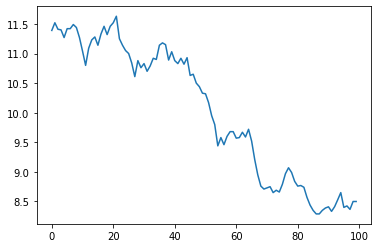

In [14]:
groups = [turn_list[x:x+100] for x in range(0, len(turn_list), 10)]
means = [sum(group)/len(group) for group in groups]

seaborn.lineplot(x=range(len(means)), y=means)

<AxesSubplot:>

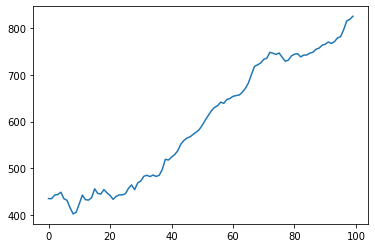

In [15]:
groups = [r_list[x:x+100] for x in range(0, len(r_list), 10)]
means = [sum(group)/len(group) for group in groups]

seaborn.lineplot(x=range(len(means)), y=means)

In [16]:
model.save('AllStepsNegModel')

INFO:tensorflow:Assets written to: AllStepsNegModel/assets
